In [3]:
0.7799*0.5+0.5*(1-0.3678 )
# (x): 0.7799	D(G(z)): 0.3678

0.7060500000000001

### Reference
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html <br>
https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf <br>
https://arxiv.org/pdf/1511.06434.pdf <br>
https://github.com/soumith/ganhacks

### What is a GAN?
We will discuss briefly what is the main concept of ***GAN: Generative Adversarial Networks*** and then get into the coding details.
The researcher Dr. Ian GOODEFEELOW first introduced GAN in 2014. https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf <br> 
This method learns to mimic any input data distribution. <br>
**One advantage of GANs** is that it helps increase the amount of data by generating new samples that follow the same distribution of the original existing ones. <br><br> 
**A GAN consists** of two opponent (adversarial) networks the generator and the discriminator, each working against the other.<br> <br> 
The generator tends to output samples with a distribution similar to the original existing data. However, the discriminator tends to identify if the input sample is real (i.e. comes from the original data) or generated (i.e. comes from the generator). <br> <br> 
**The main purpose of a GAN** is to create a good generator able to produce data samples that are creative, with large variety and that look real without memorizing the original data samples;because, what would be the advantage if it produces exactly the same original data? <br>

### Architecture of a GAN
We can think of the GAN’s structure as a game with well-defined profit functions that each of the two players tries to get the maximum possible profit. In this game, there are two opposing networks: 
- The first is the generator: it is the top interesting model in the learning; its role is to generate data samples with similar distribution of the ones in the training set.
- The second is the discriminator: his role is to check if the input sample is real or generated.

The block diagram below shows with more details the GAN’s architecture. <br> 
It all starts with the discriminator, the very first iteration, we feed it one real sample **x** that goes through a differentiable function **D** (that can be learned with gradient descent) and it outputs the probability that the sample is real, in this case, **D(x)** close to 1. This result is then back propagated to the generator. <br><br> 
The **generator** samples from a latent space a random vector **z** from a standard normal distribution. z goes through a differentiable function **G** (a shallow or deep network that can be learned with gradient descent) to finally output a sample that ideally should have a similar distribution of the original input data. <br>
This sample is then fed to the discriminator that tends to output **D(G(z))** close to 0 i.e. saying that the sample comes from the generated data. However the generator wants it to output D(G(z)) close to 1. In other terms, the discriminator wants to minimize D(G(z)) and maximize D(x) i.e. maximize D(x) and 1-D(G(z)); such that x is a real sample and G(z) is a generated sample. In the opposite, the generator will minimize 1-D(G(z)) i.e. maximize –(1-D(G(z)) ). For that purpose, Dr. GOODFELLOW has chosen to use the binary log loss as a loss function that both networks try to improve in opposite ways; and that’s from where the “adversarial” term comes from. <br> 
This process of Generation/discrimination helps the generator updates its mapping function G to produce samples that are more real and succeeds into fooling the discriminator.<br> <br> 
**NB:** the loss function used for the generator while training is simply D(G(z)) for mathematical reasons. The discriminator tends to be faster in learning than the generator i.e. D(G(z)) will always be a value close to 0 in the very first iterations. Thus -log(1-D(G(z))) would be a huge number, and maximizing an already huge number gets the generator into saturation i.e. it stops learning and generates one exact random pattern; this behavior is known as mode collapse. However, if we use log(D(G(z))), if the value of D(G(z)) is close to 0, the value of log(D(G(z)) is a very small value that the generator will tend to improve and thus continues learning. 
![title](block_diagram_GAN.png)
### What is a DCGAN?
**DCGAN** stands for **Deep Convolutional Generative Adversarial Networks**. <br>
It is an extension of GANs which uses **Convolutions** in the **discriminator** and **transpose-convolutions** in the **generator**. It was introduced by Radford et al. in the **DCGAN paper https://arxiv.org/pdf/1511.06434.pdf.** <br>
- The discriminator consists of a succession of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 image and the output is the probability that the input is from the real data distribution i.e. a scalar. 
- The generator consists of a succession of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, z sampled from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as the image.

For all the other network **hyparparameters** i.e. choice of optimizers, loss function, initial weights,etc., we will folow the **tips of the DCGAN paper**.

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed) # Sets the seed for generating random numbers

Random Seed:  999


### Inputs
Let’s define some inputs for the run:
- **dataroot:** the path to the root of the dataset folder. We will talk more about the dataset in the next section
- **workers:** the number of worker threads for loading the data with the DataLoader
- **batch_size:** the batch size used in training. The DCGAN paper uses a batch size of 128
- **image_size:** the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
- **nc:** number of color channels in the input images. For color images this is 3
- **nz:** length of latent vector
- **ngf:** relates to the depth of feature maps carried through the generator
- **ndf:** sets the depth of feature maps propagated through the discriminator
- **num_epochs:** number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
- **lr:** learning rate for training. As described in the DCGAN paper, this number should be 0.0002
- **beta1:** beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
- **ngpu:** number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [43]:
# Root directory for dataset
dataroot = "data/celeba/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode. I do not have a GPU
ngpu = 0

### Data
dataset = the **Celeb-A Faces dataset** which can be downloaded from the linked site: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html , or in Google Drive: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg . 
1. Download the file named img_align_celeba.zip 
2. Once downloaded, create a directory named celeba
3. Extract the zip file into that directory
4. Set the dataroot input for this notebook to the celeba directory you just created. 
your path should be: <br>
/path/to/celeba/img_align_celeba/ <br>
        000001.jpg <br>
        ... <br>
**NB:** if you got an error as data quota exceeded for this file google drive: make a copy of the file img_align_celeba.zip in your google drive and then download this copy <br>
The resulting directory structure should be:
<br>
This is an important step because we will be using the ImageFolder dataset class, which requires the existence of subdirectories in the dataset’s root folder. <br>
Now, we can create using Pytorch dataset library the **dataset**, create the **dataloader**, set the **device to run on**, and finally visualize some of the training data.

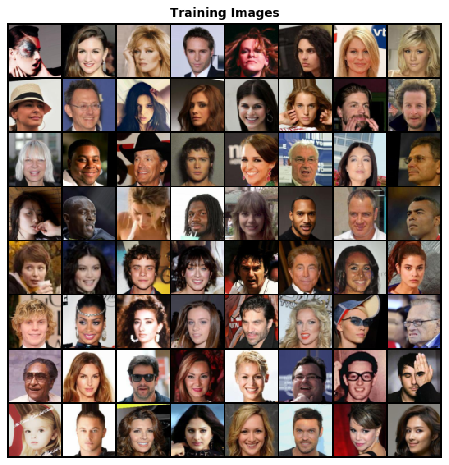

In [44]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),# here the image is a 3-channel image i.e. we set a mean and standard deviation for each channel => the mean is a tuple of 3 elements also the stdevs
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
# 'cuda:X' where X is the result of torch.cuda.current_device().
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Implementation
In this section, we will discuss respectively:
- the weigth initialization strategy
- the Generator and discriminator's networks
- the loss function
- and the training loop

#### 1. Weight Initialization
Following the DCGAN paper, all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.
<br> 
Here's an **extract of the DCGAN paper:**
*All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. <br> 
All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02. In the LeakyReLU, the slope of the leak was set to 0.2 in all models. <br>
While previous GAN work has used momentum to accelerate training, we used the Adam optimizer (Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. Additionally, we found leaving the momentum term beta1 at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.*
<br><br> The ***weights_init*** function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

**Questions:**
- Why do we initialize the batchnormalization layers to a non zero-centered Normal distribution here in the code???

**PS:**
- torch.nn.init.normal_(tensor, mean, std) : Fills the input Tensor with values drawn from the normal distribution N(mean, stdev^2)
- torch.nn.init.constant_(tensor, val): Fills the input Tensor with the value \text{val}val .

In [45]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### 2.The GAN's architecture
Let us first recall the Architecture guidelines of the ***DCGAN paper***: <br><br>
***Architecture guidelines for stable Deep Convolutional GANs:***
- *Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).*
- *Use batchnorm in both the generator and the discriminator.*
- *Remove fully connected hidden layers for deeper architectures.*
- *Use ReLU activation in generator for all layers except for the output, which uses Tanh.*
- *Use LeakyReLU activation in the discriminator for all layers.*

#### 2.a. The generator's architecture *G*
G is designed to map the ***latent space vector (z)*** to our data-space, here, RGB images with the same size as the training images (i.e. 3x64x64). <br>
In practice, this is accomplished through a series of **strided two dimensional convolutional transpose layers**, each paired with a **2d batch norm layer** and a **relu activation**. <br>
The **output of G** goes through a **tanh function** to return it to the input data range of [−1,1]. <br>
**NB:** batch norm layers after the conv-transpose layers; a critical contribution of the DCGAN paper; help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.
![title](Generator_diagram_DCGAN_paper.png)

The inputs (nz, ngf, and nc) influence the generator architecture. <br>
nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.
<br>
After building the generator's class, we instantiate a generator instance and apply the weights_init function. <br>
We also print the model to see how the generator object is structured.<br>
**PS:**
- the nbr of padding is calculated via the formula: Wout = (Win - K +2P)/S +1 for example S = 1, K = 4, Win = input width = 4, Wout = output width = 8 => P = 2; it is applied for width and height but here width = height so we will do it once
- torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros'). ***the groups parameters*** controls the connections between inputs and outputs. in_channels and out_channels must both be divisible by groups. For example,
    - At groups=1, all inputs are convolved to all outputs.
    - At groups=2, the operation becomes equivalent to having two conv layers side by side, each seeing half the input channels, and producing half the output channels, and both subsequently concatenated.
    - At groups= in_channels, each input channel is convolved with its own set of filters (of size floor(out_channels/in_channels))

In [48]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4 = 512 x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8 = 256 x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16 = 128 x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32 = 64 x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64 = 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [49]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### 2.b. The discriminator's architecture *D*
As mentioned, the discriminator **D** is a **binary classification network** that:
- Takes an image as input, here a 3x64x64 input image 
- Processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers
- And outputs through a Sigmoid activation function a final scalar probability that the input image is real (as opposed to fake). 

After building the discriminator's class, we instantiate a discriminator instance and apply the weights_init function. <br>
We also print the model to see how the discriminator object is structured.<br>

***PS:*** <br>
This architecture can be extended with ***more layers if necessary*** for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. <br>
The DCGAN paper mentions it is a ***good practice*** to use ***strided convolution rather than pooling to downsample*** because it lets the network learn its own pooling function. <br>
Also ***batch norm and leaky relu*** functions promote ***healthy gradient flow*** which is critical for the learning process of both G and D.

In [50]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [52]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### 2.c. Loss Functions and Optimizers
We will use the **Binary Cross Entropy loss (BCELoss)** function which is defined in PyTorch as:<br>
torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean') <br>
l(x,y) = L = {l1, l2, ..., lN} <br>
s.t. N = batch size, li = -wi.[yi.log(xi) + (1-yi).log(1-xi) ] and yi should be numbers between 0 and 1. <br>
L's shape differ with the choice of the ***reduction*** parameter:
- l(x,y) = mean(L) if reduction=mean => L.shape = (N,1) 
- l(x,y) = sum(L) if reduction=sum => L.shape = (N,1) 
- l(x,y) = L if reduction=sum => L.shape = (N,input_shape) 

We can specify what part of the BCE equation to use with the y input. This is accomplished in the training loop which is coming up soon, but it is important to understand how we can choose which component we wish to calculate just by changing y.
<br>
Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of D and G, and this is also the convention used in the original GAN paper. 
<br>
Finally, we set up two separate optimizers, one for D and one for G. 
<br>
As specified in the DCGAN paper, **both** are **Adam optimizers with learning rate 0.0002 and Beta1 = 0.5**. 
<br>
To keep track of the generator’s learning progression, we will generate a fixed batch of latent vectors drawn from a Gaussian distribution (i.e. fixed_noise) . In the training loop, we will periodically input this fixed_noise into G, and over the iterations we will see images form out of the noise. <br>

**NB:** the input and output should have the same shape.

In [53]:
# Initialize BCELoss function
criterion = nn.BCELoss() # by default it returns the mean loss of all the batch

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### 3.Training

Finally, now that we have all of the GAN framework defined, we can train it. <br>
*Keep in mind that training GANs is somewhat of an art form, as **incorrect hyperparameter settings lead to mode collapse** with little explanation of what went wrong.* <br>
Here, we will closely follow Algorithm 1 from Goodfellow’s paper, while abiding by some of the best practices shown in **GAN hacks** https://github.com/soumith/ganhacks. 
Namely, we will:
- ***construct different mini-batches for real and fake images*** 
- and also ***adjust G’s objective function to maximize logD(G(z))***. 

Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.<br>

##### Part 1 - Train the Discriminator

The goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake.<br>
In terms of Goodfellow, we wish to *update the discriminator by **ascending** its stochastic gradient*. 
<br>
Practically, we want to **maximize log(D(x))+log(1−D(G(z)))**. 
<br>
Due to the **separate mini-batch suggestion from GAN hacks**, we will calculate this in two steps. 
<br>
1. we will construct a batch of real samples from the training set, forward pass through D, calculate the loss (log(D(x))), then calculate the gradients in a backward pass. 
2. we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss (log(1−D(G(z)))), and accumulate the gradients with a backward pass. 
3. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

##### Part 2 - Train the Generator

The goal of training the Generator is to minimize log(1−D(G(z))) in an effort to generate better fakes. 
<br>
***As mentioned, this was shown by Goodfellow to not provide sufficient gradients (Taking into consideration that the discriminator has an easier task than the geneartor i.e. tends to learn faster. Thus, D(G(z)) is always near 0 => log(1-D(G(z))) stops changing => the generator never converge, hence, the need for an adaptive strategy to avoid such behavior), especially early in the learning process.***
<br>
As a fix, we instead wish to **maximize log(D(G(z)))**. In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the log(x) part of the BCELoss (rather than the log(1−x) part) which is exactly what we want.
<br>

In [3]:
import torch
torch.randn(128, 100, 1, 1).shape

torch.Size([128, 100, 1, 1])

In [60]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch - device is a torch.device
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # the batch size
        # real_label = 1
        # torch.full creates a tensor of size b_size filled with the same value = real_label (previously defined) = 1
        label = torch.full(size=(b_size,), fill_value=real_label, device=device) # returns a tensor of size size filled with fill_value.
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        # here we know the data are all real, thus, we expect that the D figured this out i.e. output is a tensor of 
        # proba values close to 1
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label) # the old tensor called "label" that was created by torch.full is updated and re-filled with 
        # another value = fake_label (previously defined) = 0, because we know that these samples are the generator's outputs =>
        # fake ones and we want to train the discriminator to identify them
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1) 
        # detach() Returns a new Tensor, detached from the current graph.
        # The result will never require gradient.
        # we use fake.detach() because we do not want to modify the values inside the tensor <<fake>>=netG(noise)
        # without detach() the values are changed to the values netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost, here we are training the generator unlike previously
        # thus we want to teach the generator to achieve his goal: which is fooling the discriminator i.e. netD(fake).view(-1) 
        # values close to 1
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 0.3456	Loss_G: 15.3731	D(x): 0.9571	D(G(z)): 0.2255 / 0.0000
[0/5][50/1583]	Loss_D: 0.1466	Loss_G: 19.8915	D(x): 0.9493	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.3772	Loss_G: 4.2383	D(x): 0.8586	D(G(z)): 0.1002 / 0.0224
[0/5][150/1583]	Loss_D: 0.9841	Loss_G: 3.5414	D(x): 0.5568	D(G(z)): 0.0164 / 0.0447
[0/5][200/1583]	Loss_D: 1.8424	Loss_G: 12.8544	D(x): 0.9393	D(G(z)): 0.7481 / 0.0000
[0/5][250/1583]	Loss_D: 0.3404	Loss_G: 4.3505	D(x): 0.9103	D(G(z)): 0.1838 / 0.0263
[0/5][300/1583]	Loss_D: 0.7125	Loss_G: 4.7014	D(x): 0.5879	D(G(z)): 0.0103 / 0.0215
[0/5][350/1583]	Loss_D: 0.4549	Loss_G: 3.0663	D(x): 0.8227	D(G(z)): 0.1558 / 0.0800
[0/5][400/1583]	Loss_D: 0.8045	Loss_G: 7.6447	D(x): 0.8492	D(G(z)): 0.3710 / 0.0019
[0/5][450/1583]	Loss_D: 0.3143	Loss_G: 5.5063	D(x): 0.9361	D(G(z)): 0.1793 / 0.0076
[0/5][500/1583]	Loss_D: 0.4036	Loss_G: 4.4912	D(x): 0.8518	D(G(z)): 0.1645 / 0.0240
[0/5][550/1583]	Loss_D: 0.6068	Loss_G: 3.0428	D(x)

[3/5][50/1583]	Loss_D: 0.8352	Loss_G: 3.8148	D(x): 0.9433	D(G(z)): 0.4940 / 0.0320
[3/5][100/1583]	Loss_D: 0.5661	Loss_G: 1.3379	D(x): 0.7260	D(G(z)): 0.1770 / 0.2980
[3/5][150/1583]	Loss_D: 0.7955	Loss_G: 1.2348	D(x): 0.5436	D(G(z)): 0.0761 / 0.3413
[3/5][200/1583]	Loss_D: 0.9151	Loss_G: 1.5033	D(x): 0.5418	D(G(z)): 0.1232 / 0.3139
[3/5][250/1583]	Loss_D: 1.6128	Loss_G: 4.9834	D(x): 0.9393	D(G(z)): 0.7238 / 0.0118
[3/5][300/1583]	Loss_D: 0.5658	Loss_G: 2.3922	D(x): 0.7839	D(G(z)): 0.2418 / 0.1147
[3/5][350/1583]	Loss_D: 1.0282	Loss_G: 5.2509	D(x): 0.9378	D(G(z)): 0.5673 / 0.0084
[3/5][400/1583]	Loss_D: 0.6534	Loss_G: 2.8337	D(x): 0.7767	D(G(z)): 0.2787 / 0.0774


KeyboardInterrupt: 

##### Statitic Reporting
Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:

- Loss_D: discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(D(G(z)))).
- Loss_G: generator loss calculated as log(D(G(z)))
- D(x): the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
- D(G(z)) = D_G_z1(after training the Discriminator)/D_G_z2(after training the generator): average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better.

**NB:** This step might take a while, depending on how many epochs you run and if you removed some data from the dataset.

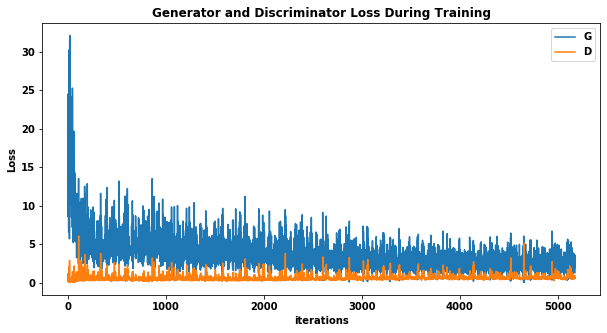

In [61]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Visualization of G’s progression

Remember how we saved the generator’s output on the fixed_noise batch after every epoch of training. Now, we can visualize the training progression of G with an animation. Press the play button to start the animation.

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

#### Real Images vs. Fake Images

Finally, lets take a look at some real images and fake images side by side.

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()